# Полносвязные нейронные сети на примере классификации вина по качеству

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas_profiling
import warnings
warnings.filterwarnings("ignore")
matplotlib.style.use('seaborn-pastel')
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузим датасет и посмотрим на данные.

- `fixed acidity` - фиксированная кислотность
- `volatile acidity` - летучая кислотность
- `citric acid` - лимонная кислота
- `residual sugar` - остаточный сахар
- `chlorides` - хлориды
- `free sulfur dioxide` - свободный диоксид серы
- `total sulfur dioxide` - диоксид серы общий
- `density` - плотность
- `pH` - рН
- `sulphates` - сульфаты
- `alcohol` - алкоголь
- `quality` - качество (оценка от 0 до 10), выходная переменная

In [ ]:
df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/Lesson 0309/winequality-white.csv", delimiter=';'
)

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Не забываем посмотреть на данные глазками

In [ ]:
#df.profile_report()

И дополнительно на то, что нам придется предсказать

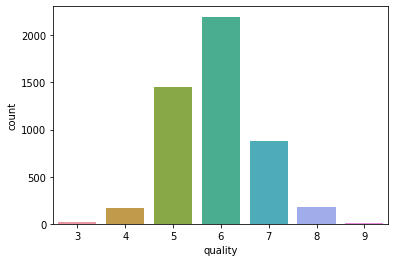

In [ ]:
sns.countplot(x="quality", data=df)

По классике разделим признаки и ответы

In [ ]:
x = df.copy()
y = df['quality'] - 3
del x['quality']

Разделим выборку на обучающую и валидационную в соотношении 80 на 20

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x, y, random_state=42, train_size=0.8, stratify=y, shuffle=True
)

### Простая нейронная сеть

Для начала импортируем библиотеки, которые нам понадобятся

https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Создадим свою сеть

In [ ]:
x_train.shape

(3918, 11)

In [ ]:
print(f'= {y_train.unique() } ')
print(f'= {len(y_train.unique())  }')

= [4 2 3 5 1 0 6] 
= 7


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Первый (входной) полносвязный слой
        # Количество входов = кол-ву признаков
        self.fc1 = nn.Linear(11, 64, dtype=torch.float64)
        # Второй (выходной) полносвязный слой
        # Количество выходов = кол-ву значений в целевой переменной
        self.fc2 = nn.Linear(64, 7, dtype=torch.float64)

    def forward(self, x):
        # прямой проход
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        # в конце применяем софтмакс
        output = F.softmax(x, dim=0)
        return output

my_nn = Net()
print(my_nn)

Net(
  (fc1): Linear(in_features=11, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=7, bias=True)
)


In [ ]:
torch.tensor(x_train.iloc[0].to_numpy()).double()

AttributeError: ignored

In [ ]:
my_nn = Net()
result = my_nn(torch.tensor(x_train.iloc[0].to_numpy()).double())
print(result)

AttributeError: ignored

#### Обучение

In [ ]:
import torch.optim as optim
from torch.autograd import Variable

Настроим оптимизатор и функцию потерь.

<!-- За этими двумя строками кода скрывается довольно много вещей, поэтому,
если вы не знаете, что здесь происходит, пока не беспокойтесь слишком
сильно, со временем все станет яснее. -->

Оптимизатор — это то, что обновляет параметры сети.
Возьмем популярный оптимизатор Adam.

https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD

https://pytorch.org/docs/stable/optim.html

<!-- Я буду использовать стохастический градиентный спуск с импульсом.
Кроме того, оптимизатор принимает параметры сети в качестве аргумента,
но это не имеет большого значения, поскольку мы можем получить их
с помощью функции `.parameters()`. -->

В качестве функции потерь будем использовать кросс энтропию
Cross Entropy Loss.

https://pytorch.org/docs/stable/nn.html#loss-functions

<!-- Я решил использовать Cross Entropy Loss для этой задачи, но опять же,
есть много вариантов, и вы можете выбрать то, что вам больше подходит. -->

In [ ]:
optimizer = optim.Adam(my_nn.parameters(), lr=0.05)
loss_func = nn.CrossEntropyLoss()

Определим ряд переменных для лучшего понимания

In [ ]:
epochs = 20
batch_size = 32

Цикл обучения

In [ ]:
x_train.shape

(3918, 11)

In [ ]:
loss_log = []

# цикл по эпохам
for e in range(epochs):
    # цикл по всем батчам
    for i in range(0, x_train.shape[0], batch_size):
        # руками выберем батчи
        x_batch = x_train[i:i + batch_size] 
        y_batch = y_train[i:i + batch_size] 

        # превратим их в тензоры с оберткой
        x_var = Variable(torch.tensor(x_batch.to_numpy()))
        y_var = Variable(torch.tensor(y_batch.to_numpy()))

        # обнулим градиент
        optimizer.zero_grad()
        # посчитаем выход
        net_out = my_nn(x_var)

        # вычислим значение функции потерь
        loss = loss_func(net_out, y_var)
        # совершим обратный проход (обратное распространение)
        loss.backward()
        # сделаем шаг оптимизации, обновим веса
        optimizer.step()

        # запишем значение для контроля обучения
        if i % 100 == 0:
            loss_log.append(loss.item())

    print(f'Epoch: {e} - Loss: {loss.item():.6f}')

AttributeError: ignored

Визуализируем обучение

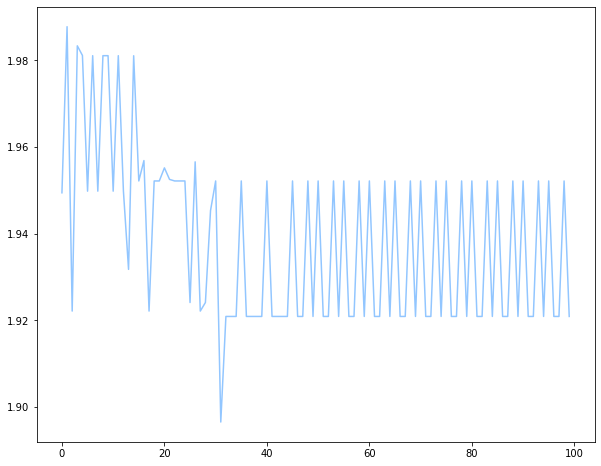

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(loss_log)

Попробуем добавить слоев

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(11, 32, dtype=torch.float64)
        self.fc2 = nn.Linear(32, 16, dtype=torch.float64)
        self.fc3 = nn.Linear(16, 8, dtype=torch.float64)
        self.fc4 = nn.Linear(8, 7, dtype=torch.float64)

    def forward(self, x):
        # прямой проход
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        # в конце применяем софтмакс
        output = F.softmax(x, dim=0)
        return output

my_nn2 = Net2()
print(my_nn2)

Net2(
  (fc1): Linear(in_features=11, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=7, bias=True)
)


In [ ]:
optimizer = optim.SGD(my_nn.parameters(), lr=0.05, momentum=0.8)
loss_func = nn.CrossEntropyLoss()

In [ ]:
loss_log = []

# цикл по эпохам
for e in range(epochs):
    # цикл по всем батчам
    for i in range(0, x_train.shape[0], batch_size):
        # руками выберем батчи
        x_batch = x_train[i:i + batch_size] 
        y_batch = y_train[i:i + batch_size] 

        # превратим их в тензоры с оберткой
        x_var = Variable(torch.tensor(x_batch.to_numpy()))
        y_var = Variable(torch.tensor(y_batch.to_numpy()))

        # обнулим градиент
        optimizer.zero_grad()
        # посчитаем выход
        net_out = my_nn(x_var)

        # вычислим значение функции потерь
        loss = loss_func(net_out, y_var)
        # совершим обратный проход (обратное распространение)
        loss.backward()
        # сделаем шаг оптимизации, обновим веса
        optimizer.step()

        # запишем значение для контроля обучения
        if i % 100 == 0:
            loss_log.append(loss.item())

    print(f'Epoch: {e} - Loss: {loss.item():.6f}')

Epoch: 0 - Loss: 1.960211
Epoch: 1 - Loss: 1.960211
Epoch: 2 - Loss: 1.960211
Epoch: 3 - Loss: 1.960211
Epoch: 4 - Loss: 1.960211
Epoch: 5 - Loss: 1.960211
Epoch: 6 - Loss: 1.960211
Epoch: 7 - Loss: 1.960211
Epoch: 8 - Loss: 1.960211
Epoch: 9 - Loss: 1.960211
Epoch: 10 - Loss: 1.960211
Epoch: 11 - Loss: 1.960211
Epoch: 12 - Loss: 1.960211
Epoch: 13 - Loss: 1.960211
Epoch: 14 - Loss: 1.960211
Epoch: 15 - Loss: 1.960211
Epoch: 16 - Loss: 1.960211
Epoch: 17 - Loss: 1.960211
Epoch: 18 - Loss: 1.960211
Epoch: 19 - Loss: 1.960211


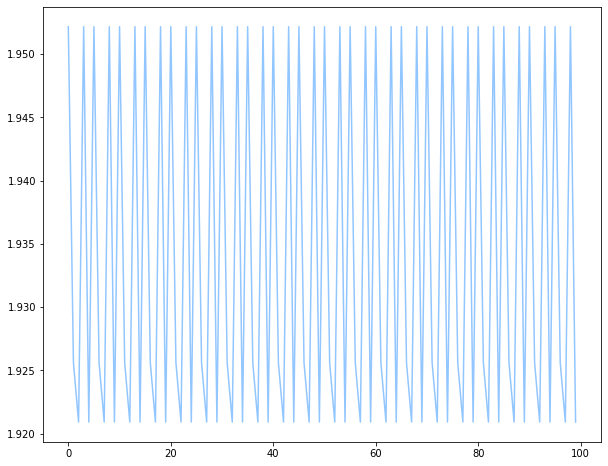

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(loss_log)